In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn import metrics
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.2)

In [2]:
data = pd.read_csv('transactions_new.csv', sep=',')
data.describe()

,timestamp,villa,size,latitude,longitude,price
count,2.403130e+05,240313.000000,240313.000000,240313.000000,240313.000000,240313.000000
mean,1.393203e+09,0.029595,1253.718559,25.100762,55.230110,13.726785
std,1.185367e+08,0.169467,1155.478975,0.058595,0.107643,0.812514
min,1.077926e+09,0.000000,1.000000,24.861898,55.027290,0.000000
25%,1.296950e+09,0.000000,711.000000,25.068769,55.143979,13.122363
50%,1.380586e+09,0.000000,957.000000,25.088770,55.205834,13.682317
75%,1.477267e+09,0.000000,1471.000000,25.161231,55.278923,14.274200
max,1.632614e+09,1.000000,44800.000000,25.305823,55.508141,19.644456


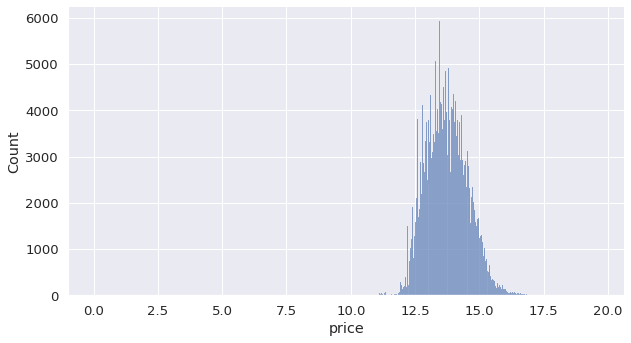

In [3]:
sns.displot(
  data=data,
  x="price",
  kind="hist",
  aspect=1.8
)

In [4]:
data.isna().sum()

timestamp    0
villa        0
size         0
latitude     0
longitude    0
price        0
dtype: int64

load the models we saved in `updated` notebook and use that to overwrite asking and rental columns

In [6]:
X = data.drop(['price', 'timestamp'], axis=1)
y = data['price']

In [5]:
import pickle
# load the model from disk
ask_model = pickle.load(open('ask_model.sav', 'rb'))
ren_model = pickle.load(open('ren_model.sav', 'rb'))

In [7]:
data['asking'] = ask_model.predict(X)
data.head()

,timestamp,villa,size,latitude,longitude,price,asking
0,1441152000,1,18675,25.245967,55.294998,15.607270,16.813404
1,1297555200,1,3600,25.224727,55.268742,14.269765,15.211076
2,1587859200,1,3300,25.224727,55.268742,14.603968,15.337697
3,1364083200,1,3300,25.224727,55.268742,14.603968,15.337697
4,1196726400,1,3300,25.224727,55.268742,14.926710,15.337697


In [8]:
data['rental'] = ren_model.predict(X)
data.head()

,timestamp,villa,size,latitude,longitude,price,asking,rental
0,1441152000,1,18675,25.245967,55.294998,15.607270,16.813404,13.107218
1,1297555200,1,3600,25.224727,55.268742,14.269765,15.211076,11.818392
2,1587859200,1,3300,25.224727,55.268742,14.603968,15.337697,12.126193
3,1364083200,1,3300,25.224727,55.268742,14.603968,15.337697,12.126193
4,1196726400,1,3300,25.224727,55.268742,14.926710,15.337697,12.126193


In [9]:
## define X, y again as we dropped timestamp for rental and asking predictions
X = data.drop('price', axis=1)
y = data['price']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((192250, 7), (192250,), (48063, 7), (48063,))

In [12]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

In [13]:
model = XGBRegressor(learning_rate =  0.1,
                     max_depth =  10,
                     n_estimators = 1010,
                     nthread = -1, n_jobs=-1)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1010, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [14]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.14691797393312972
MSE: 0.05657465330567965
RMSE: 0.2378542690507775
R2 Square 0.9153087328488948
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.09577328853920791
MSE: 0.020522068261430042
RMSE: 0.1432552556153876
R2 Square 0.9688217334183427
__________________________________


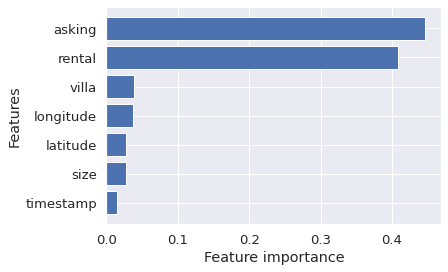

In [15]:
def plot_features(columns, importances, n=10):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()
    
    
plot_features(X_train.columns, model.feature_importances_)

## `lets preprocess the data and see if we get better results!`

In [16]:
# lets remove the outliers

print(f'shape of the orignal dataset: {data.shape}')
z_scores = stats.zscore(data)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_data = data[filtered_entries]

print(f'shape after removing outliers: {new_data.shape}')

shape of the orignal dataset: (240313, 8)
shape after removing outliers: (230453, 8)


In [18]:
240313-230453

9860

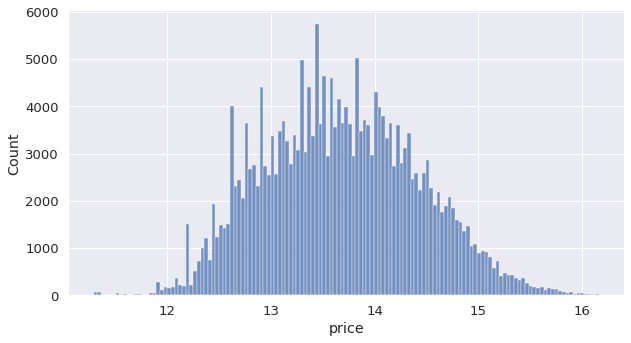

In [19]:
sns.displot(
  data=new_data,
  x="price",
  kind="hist",
  aspect=1.8
)

In [20]:
X = new_data.drop('price', axis=1)
y = new_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = XGBRegressor(learning_rate =  0.1,
                     max_depth =  10,
                     n_estimators = 1010,
                     nthread = -1, n_jobs=-1)

model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)


print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

Test set evaluation:
_____________________________________
MAE: 0.14610964873491147
MSE: 0.05058161736644523
RMSE: 0.2249035734852722
R2 Square 0.9103608650847306
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.09409830823854175
MSE: 0.019802110103045535
RMSE: 0.14071997051963
R2 Square 0.9648972571558634
__________________________________


## tune hyperparameters

In [24]:
### Hyperparameters tuning
from sklearn.model_selection import GridSearchCV
xgb1 = XGBRegressor()
parameters = {'learning_rate': [0.3, 0.03, 0.1]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=False)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
0.8922432142767945
{'learning_rate': 0.3}


In [26]:
parameters = {'max_depth': [5,10,15]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=1)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.902937673719601
{'max_depth': 10}


In [27]:

parameters = {'n_estimators': [800,1000,1200]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=1)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.9054894521858156
{'n_estimators': 1000}


which are the same parameters we used 